In [61]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from skimage.transform import rescale
import pathlib

import warnings
warnings.simplefilter('ignore')

### Data reading & understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [62]:
DATASET_PATH = './ISIC_data/'
TEST_SUBPATH = 'Test/'
TRAIN_SUBPATH= 'Train/'

data_dir_train = pathlib.Path(os.path.join(DATASET_PATH,TRAIN_SUBPATH))
data_dir_test = pathlib.Path(os.path.join(DATASET_PATH,TEST_SUBPATH))

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))

image_count_test = len(list(data_dir_test.glob('*/*.jpg')))

print("Training images",image_count_train)
print("Test images",image_count_test)
print("total images",image_count_train + image_count_test)

Training images 2239
Test images 118
total images 2357


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.


### Create a dataset

Define some parameters for the loader:

In [63]:
batch_size = 32
img_height = 180
img_width = 180

In [64]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(DATASET_PATH,TRAIN_SUBPATH),
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  batch_size = 32,
  image_size = (img_height,img_width),
  seed = 123,
  subset = "training",
  validation_split = 0.2
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [65]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(DATASET_PATH,TEST_SUBPATH),
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  batch_size = 32,
  image_size = (img_height,img_width),
  seed = 123,
  subset = "validation",
  validation_split = 0.2
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [66]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

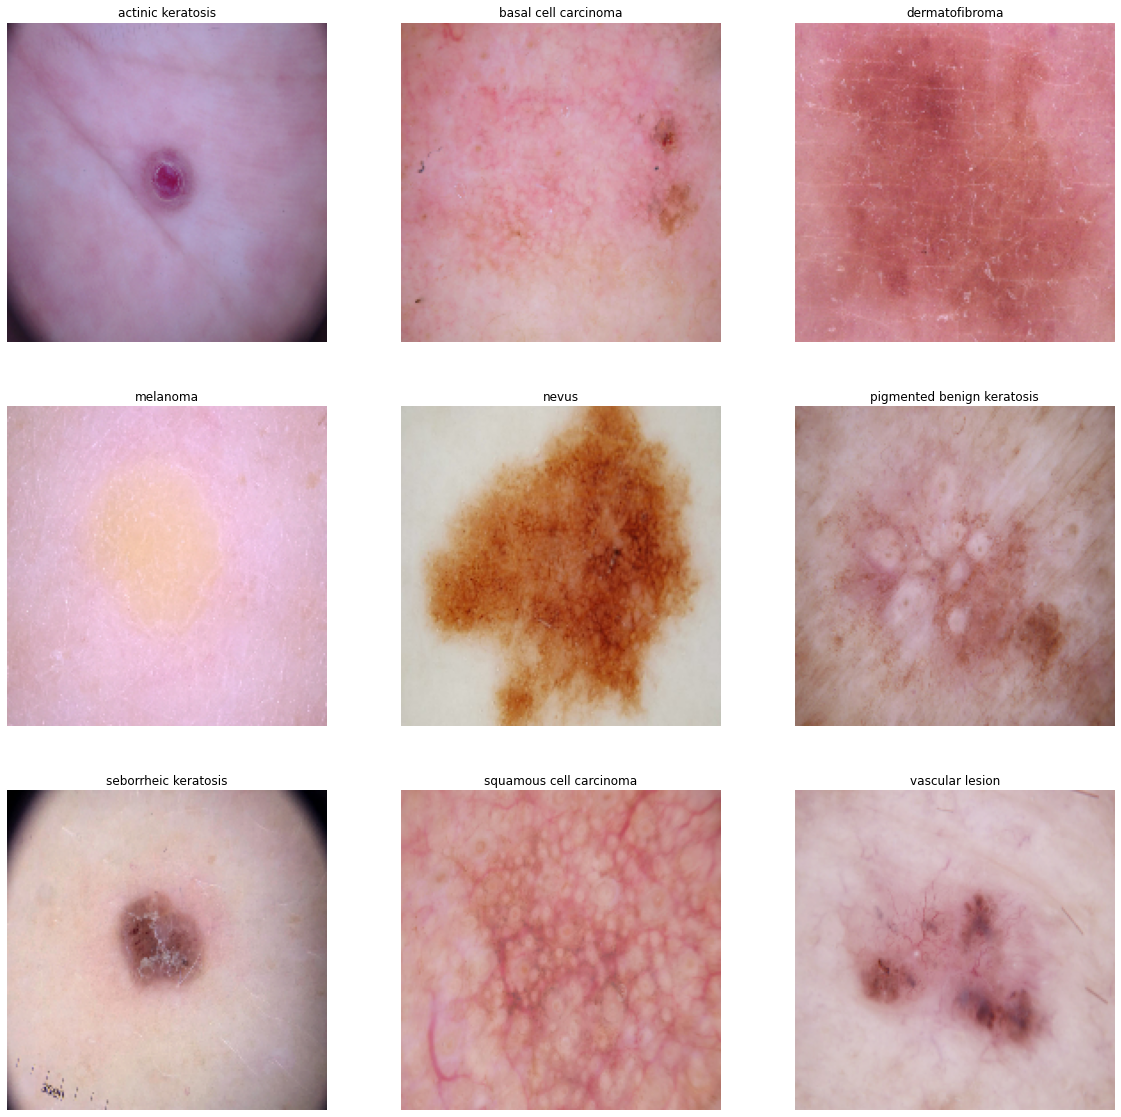

In [67]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")


In [68]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 9)


### Create the model

To create the mode we will normalize de pixel values between 0 and 1.

In [70]:
# number of epochs
epochs=20

#definition of the normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# all pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.14820248 0.9715682


In [80]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [85]:
#using  a sequential model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512),
    layers.Activation('relu'),
    #layers.Dropout(0.5),
    layers.Dense(len(class_names)),
    layers.Activation('softmax')
    
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    #layers.Dense(len(class_names),activation='softmax')
    ])
model.build(input_shape=(batch_size,img_height, img_width, 3))

In [86]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (32, 180, 180, 3)         0         
                                                                 
 conv2d_26 (Conv2D)          (32, 180, 180, 32)        896       
                                                                 
 activation_23 (Activation)  (32, 180, 180, 32)        0         
                                                                 
 conv2d_27 (Conv2D)          (32, 178, 178, 32)        9248      
                                                                 
 activation_24 (Activation)  (32, 178, 178, 32)        0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (32, 89, 89, 32)         0         
 g2D)                                                            
                                                      

### Compile the model
Choose an appropirate optimiser and loss function for model training 

Optimizer: 
The Adam Optimization algorithm is an extension of the Stochastic gradient descent that is receiving broader adoption in computer vision.

The hidden layers use the stsndard RELU activation function.

The final layer uses the softmax activation because its a multiclass problem.

Convolution layers are used after the activation function to obtain highlevel features

Loss functions used is the categorical_crossentropy loss, since we have a multi-class problem and our objective is to minimize the loss.

In [87]:
#choosing an appropirate optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [88]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 59s 1s/step - loss: 2.0282 - accuracy: 0.3058 - val_loss: 1.6569 - val_accuracy: 0.3669
Epoch 2/20
56/56 [==============================] - 60s 1s/step - loss: 1.6979 - accuracy: 0.3945 - val_loss: 1.5588 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 62s 1s/step - loss: 1.5649 - accuracy: 0.4665 - val_loss: 1.5064 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 60s 1s/step - loss: 1.4164 - accuracy: 0.5078 - val_loss: 1.4651 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 62s 1s/step - loss: 1.3361 - accuracy: 0.5301 - val_loss: 1.5096 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 60s 1s/step - loss: 1.2642 - accuracy: 0.5491 - val_loss: 1.5114 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 60s 1s/step - loss: 1.1685 - accuracy: 0.5837 - val_loss: 1.4651 - val_accuracy: 0.5034
Epoch 8/20
56/56 [==

### Visualizing training results

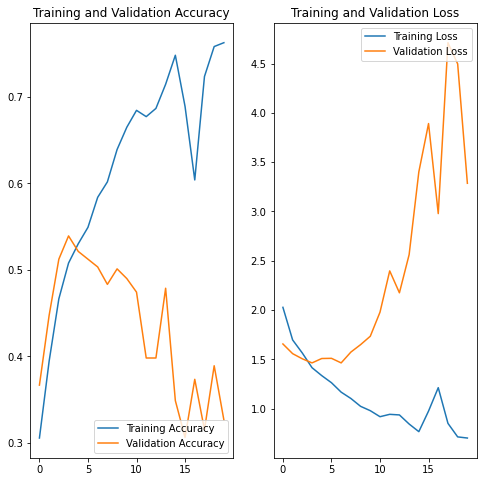

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after the model fit
Results on accurary and loss after 20 epochs

 - Training accuracy: 76%
 - Validation accuracy: 32%
 
 - Training loss: 0.70
 - Validation loss: 3.80
 
How can we identify a good model fit?

 - Will have a moderate training loss at the beginning that will gradually decreases when adding training examples and will gradually flatten. Meaning adding more training data will not improve the model performance on training data
 - Will have a hig validation loss at the beginning that will gradually decreases when adding training examples and will gradually flatten. Meaning adding more training data will not improve the model performance on new unforseen data.
 
Based on the above values we can clearly determine that the **model is overfiting**. The model works very well with training that but doesn't handle correctly on new unseen data. We also see that the loss is increasing on validation data.


### Augmentation

Augmentation is used to increase the dataset and to handle data variation. There are multiple types of augmentations possible, in this workbook are are only applying the basic ones

 1. Linear transformations
 2. Affine transformations

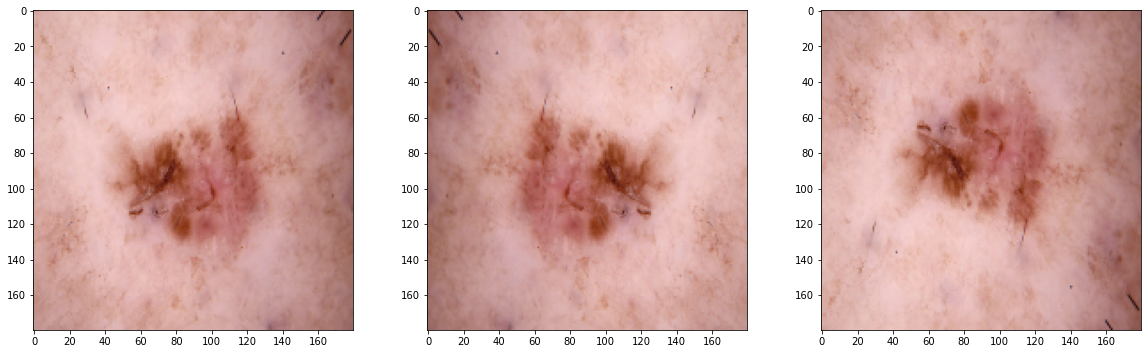

In [131]:
from skimage import transform


#example of linear transformations with flip left right and flip up down
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    ax = plt.subplot(3, 3,1)
    plt.imshow( images[0].numpy().astype("uint8"))
    
    ax = plt.subplot(3, 3,2)
    image_flipr = tf.image.flip_left_right(images[0])
    plt.imshow(image_flipr.numpy().astype("uint8"))
    
    ax = plt.subplot(3, 3, 3)
    image_flipud =  tf.image.flip_up_down(images[0])
    plt.imshow(image_flipud.numpy().astype("uint8"))
    break

Above we have shown one image and its linear tranformations. Affine transformations can also be used, such as rotation, scaling and translations. We will apply affine tranformations on thenext step in conjuntions with linear transformations.

In [157]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=os.path.join(DATASET_PATH,TRAIN_SUBPATH),
                                                     shuffle=True,
                                                     target_size=(img_height,img_width),
                                                     subset="training",
                                                     class_mode='categorical')

Found 2239 images belonging to 9 classes.


In [158]:
for image_batch, labels_batch in train_data_gen:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 9)


In [159]:
model = tf.keras.Sequential([
    #layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    #layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512),
    layers.Activation('relu'),
    #layers.Dropout(0.5),
    layers.Dense(len(class_names)),
    layers.Activation('softmax')
    
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(32, 3, activation='relu'),
    #layers.MaxPooling2D(),
    #layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    #layers.Dense(len(class_names),activation='softmax')
    ])
model.build(input_shape=(batch_size,img_height, img_width, 3))

In [160]:
# View the summary of all layers
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (32, 180, 180, 32)        896       
                                                                 
 activation_47 (Activation)  (32, 180, 180, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (32, 178, 178, 32)        9248      
                                                                 
 activation_48 (Activation)  (32, 178, 178, 32)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 89, 89, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (32, 89, 89, 64)          18496     
                                                     

In [161]:
#choosin an appropirate optimiser and loss function
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [162]:
history = model.fit(
  train_data_gen,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 140s 2s/step - loss: 2.5761 - accuracy: 0.2251 - val_loss: 42.1067 - val_accuracy: 0.1946
Epoch 2/20
70/70 [==============================] - 135s 2s/step - loss: 1.9054 - accuracy: 0.2943 - val_loss: 49.0888 - val_accuracy: 0.2058
Epoch 3/20
70/70 [==============================] - 134s 2s/step - loss: 1.8849 - accuracy: 0.2952 - val_loss: 135.7523 - val_accuracy: 0.1611
Epoch 4/20
70/70 [==============================] - 134s 2s/step - loss: 1.6972 - accuracy: 0.3734 - val_loss: 20.3769 - val_accuracy: 0.2640
Epoch 5/20
70/70 [==============================] - 133s 2s/step - loss: 1.7781 - accuracy: 0.3506 - val_loss: 38.5471 - val_accuracy: 0.2349
Epoch 6/20
70/70 [==============================] - 134s 2s/step - loss: 1.6041 - accuracy: 0.4265 - val_loss: 57.6922 - val_accuracy: 0.2170
Epoch 7/20
70/70 [==============================] - 137s 2s/step - loss: 1.4572 - accuracy: 0.4922 - val_loss: 182.9002 - val_accuracy: 0.1969
Epoc

### Visualizing training results after augmentatin strategy

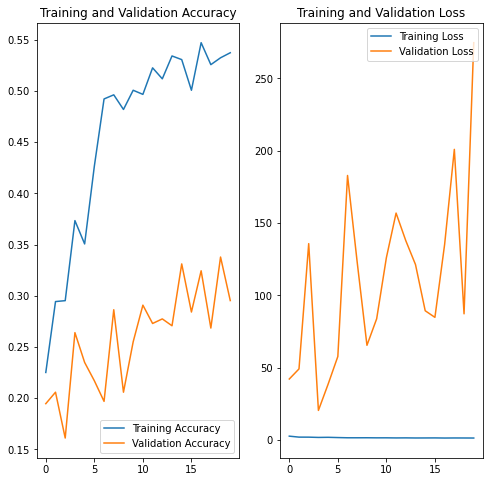

In [186]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after the model fit
Results on accurary and loss after 20 epochs

 - Training accuracy: 54%
 - Validation accuracy: 29%
 
 - Training loss: 1.27
 - Validation loss: 274

After augmentation our model training and validation accuracy have descrease from 76% to 54% and 32% to 29% respectivly.

The good news are **validation accuracy ony reduce 3%** while **training accuracy reduced 27%**. This can indicate that the model handles slightly better unseen data and the overfitting its not so strong if we see that we have a moderate training loss at the beginning that will gradually decreases when adding training examples and will gradually flatten.

We can conclude that addign more training data will not improve the model performance on training data.

The fact that we have lower accuracy can be caused by 2 issues:

 - Imbalance
     -  We have no infered if the number of images per class is significantly diferent
 - No having dropout layers on the NN
     -  Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.

### Current distribution of classes in the training dataset.

In [233]:
#couting each class value from the trainign dataset labels
distribution_dict = {i:list(train_data_gen.labels).count(i) for i in train_data_gen.labels}

maxDistribution = float(max(distribution_dict.values()))
sumDistribution = sum(distribution_dict.values())

#pritning the output
for i in range(len(class_names)):
    print(class_names[i],":",distribution_dict[i], "- {:.0%}".format( distribution_dict[i]/sumDistribution ))

actinic keratosis : 114 - 5%
basal cell carcinoma : 376 - 17%
dermatofibroma : 95 - 4%
melanoma : 438 - 20%
nevus : 357 - 16%
pigmented benign keratosis : 462 - 21%
seborrheic keratosis : 77 - 3%
squamous cell carcinoma : 181 - 8%
vascular lesion : 139 - 6%


Base on the lsit below:

 - Class with fewer elements is "seborrheic keratosis" (77) (3%)
 - Class with more elements is "pigmented benign keratosis" (462) (21%)

In [234]:
distribution_dict = dict(zip(distribution_dict.keys(), [round(v/sumDistribution,2) for v in distribution_dict.values()]))
distribution_dict

{0: 0.05,
 1: 0.17,
 2: 0.04,
 3: 0.2,
 4: 0.16,
 5: 0.21,
 6: 0.03,
 7: 0.08,
 8: 0.06}

In [235]:
history = model.fit(
  train_data_gen,
  validation_data=validation_ds,
  epochs=epochs,
  class_weight= distribution_dict
)

Epoch 1/20
70/70 [==============================] - 76s 1s/step - loss: 0.1949 - accuracy: 0.4256 - val_loss: 652.7554 - val_accuracy: 0.1946
Epoch 2/20
70/70 [==============================] - 76s 1s/step - loss: 0.1923 - accuracy: 0.4399 - val_loss: 708.8433 - val_accuracy: 0.1924
Epoch 3/20
70/70 [==============================] - 76s 1s/step - loss: 0.1920 - accuracy: 0.4319 - val_loss: 596.6837 - val_accuracy: 0.2013
Epoch 4/20
70/70 [==============================] - 76s 1s/step - loss: 0.1910 - accuracy: 0.4426 - val_loss: 705.0549 - val_accuracy: 0.2058
Epoch 5/20
70/70 [==============================] - 77s 1s/step - loss: 0.1911 - accuracy: 0.4404 - val_loss: 493.8383 - val_accuracy: 0.2192
Epoch 6/20
70/70 [==============================] - 80s 1s/step - loss: 0.1905 - accuracy: 0.4399 - val_loss: 559.2689 - val_accuracy: 0.1655
Epoch 7/20
70/70 [==============================] - 79s 1s/step - loss: 0.1904 - accuracy: 0.4386 - val_loss: 489.5092 - val_accuracy: 0.1902
Epoch 

### Visualizing training results after Imbalance strategy

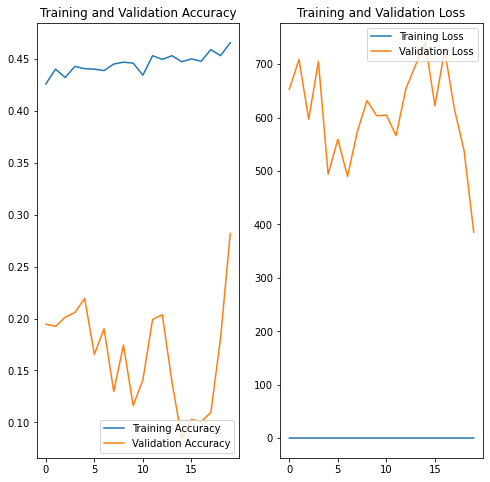

In [237]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after the model fit
Results on accurary and loss after 20 epochs

 - Training accuracy: 45%
 - Validation accuracy: 28%
 
 - Training loss: 0.18
 - Validation loss: 385

After trying to handle imbalance our model training and validation accuracy have descrease from 54% to 45% and 29% to 28% respectivly.

The good news are **validation accuracy ony reduce 1%** while **training accuracy reduced 9%**. This can indicate that the model handles better unseen data and the overfitting its not so strong if we see that we have a moderate training loss at the beginning that will gradually decreases when adding training examples and will gradually flatten.

We can conclude that addign more training data will not improve the model performance on training data.